In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from textblob import TextBlob

In [3]:
# List of stock files
stock_files = [
    r"C:\Users\Ramlla\Desktop\Financial\data\AAPL_historical_data.csv",
    r'C:\Users\Ramlla\Desktop\Financial\data\AMZN_historical_data.csv', 
    r'C:\Users\Ramlla\Desktop\Financial\data\GOOG_historical_data.csv', 
    r'C:\Users\Ramlla\Desktop\Financial\data\META_historical_data.csv', 
    r'C:\Users\Ramlla\Desktop\Financial\data\MSFT_historical_data.csv', 
    r'C:\Users\Ramlla\Desktop\Financial\data\NVDA_historical_data.csv', 
    r'C:\Users\Ramlla\Desktop\Financial\data\TSLA_historical_data.csv'
]

# Load all stock files into a list of DataFrames
stock_dfs = [pd.read_csv(file) for file in stock_files]

# Convert 'Date' columns to datetime, make timezone-aware, and set as index
for df in stock_dfs:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').apply(
        lambda dt: dt if pd.isna(dt) 
                     else dt.astimezone(pytz.UTC) if dt.tzinfo 
                     else dt.replace(tzinfo=pytz.UTC)
    )
    df.set_index('Date', inplace=True)
    # Ensure all date indices are unique
    df = df[~df.index.duplicated(keep='first')]

# Load the news data
news_df = pd.read_csv(r"C:\Users\Ramlla\Desktop\Financial\data\raw_analyst_ratings.csv")

# Convert 'Date' column to datetime, make timezone-aware, and set as index
news_df['Date'] = pd.to_datetime(news_df['date'], errors='coerce').apply(
    lambda dt: dt if pd.isna(dt) 
                 else dt.astimezone(pytz.UTC) if dt.tzinfo 
                 else dt.replace(tzinfo=pytz.UTC)
)
news_df.set_index('Date', inplace=True)
# Ensure all date indices are unique
news_df = news_df[~news_df.index.duplicated(keep='first')]

# Step 1: Align the date ranges across all DataFrames
common_start_date = max(df.index.min() for df in stock_dfs + [news_df])
common_end_date = min(df.index.max() for df in stock_dfs + [news_df])

# Convert to timezone-aware Timestamps if necessary
if not common_start_date.tzinfo:
    common_start_date = pd.Timestamp(common_start_date).tz_localize('UTC')
else:
    common_start_date = pd.Timestamp(common_start_date).tz_convert('UTC')

if not common_end_date.tzinfo:
    common_end_date = pd.Timestamp(common_end_date).tz_localize('UTC')
else:
    common_end_date = pd.Timestamp(common_end_date).tz_convert('UTC')

# Filter all DataFrames to the common date range
for i in range(len(stock_dfs)):
    df = stock_dfs[i]
    df = df.loc[common_start_date:common_end_date]
    stock_dfs[i] = df

# Ensure news_df is filtered correctly
news_df = news_df.loc[common_start_date:common_end_date]

# Step 2: Combine all stock DataFrames
combined_stock_df = pd.concat(stock_dfs, axis=1)

# Step 3: Flatten multi-level columns in the stock DataFrame (if any)
combined_stock_df.columns = combined_stock_df.columns.to_flat_index()

# Step 4: Merge stock data with news data
combined_df = pd.merge(combined_stock_df, news_df, left_index=True, right_index=True, how='inner')

# Step 5: Handle any remaining NaN values (e.g., by filling with 0)
combined_df.fillna(0, inplace=True)

# Step 6: Inspect the combined DataFrame
print(combined_df.head())

# Sentiment Analysis Section

# Assuming you have a DataFrame `news_df` with a column 'headline'
def get_sentiment(text):
    analysis = TextBlob(text)
    # Get polarity score: -1 (negative) to 1 (positive)
    return analysis.sentiment.polarity

# Apply sentiment analysis to news headlines
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Optionally categorize sentiment into positive, neutral, negative
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'negative'

news_df['sentiment_category'] = news_df['sentiment'].apply(categorize_sentiment)

# Inspect sentiment analysis results
print(news_df.head())
print(news_df.columns)


                                Open       High        Low      Close  \
Date                                                                    
2012-12-12 00:00:00+00:00  19.563213  19.571428  19.152500  19.250000   
2012-12-14 00:00:00+00:00  18.383928  18.504642  18.056429  18.206785   
2012-12-17 00:00:00+00:00  18.176071  18.571428  17.901072  18.529642   
2012-12-21 00:00:00+00:00  18.302500  18.559643  18.222857  18.547501   
2012-12-24 00:00:00+00:00  18.583929  18.723213  18.525356  18.577499   

                           Adj Close      Volume  Dividends  Stock Splits  \
Date                                                                        
2012-12-12 00:00:00+00:00  16.400513   487144000        0.0           0.0   
2012-12-14 00:00:00+00:00  15.511719  1009579200        0.0           0.0   
2012-12-17 00:00:00+00:00  15.786786   757607200        0.0           0.0   
2012-12-21 00:00:00+00:00  15.802008   596268400        0.0           0.0   
2012-12-24 00:00:00+00:00 

Columns after deduplication:
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')
Columns in news_df:
Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock',
       'sentiment', 'sentiment_category'],
      dtype='object')
Correlation of sentiment with stock returns:
Empty DataFrame
Columns: []
Index: [Open, High, Low, Close, Adj Close, Volume, Dividends, Stock Splits, Close_Return, Adj Close_Return, sentiment]


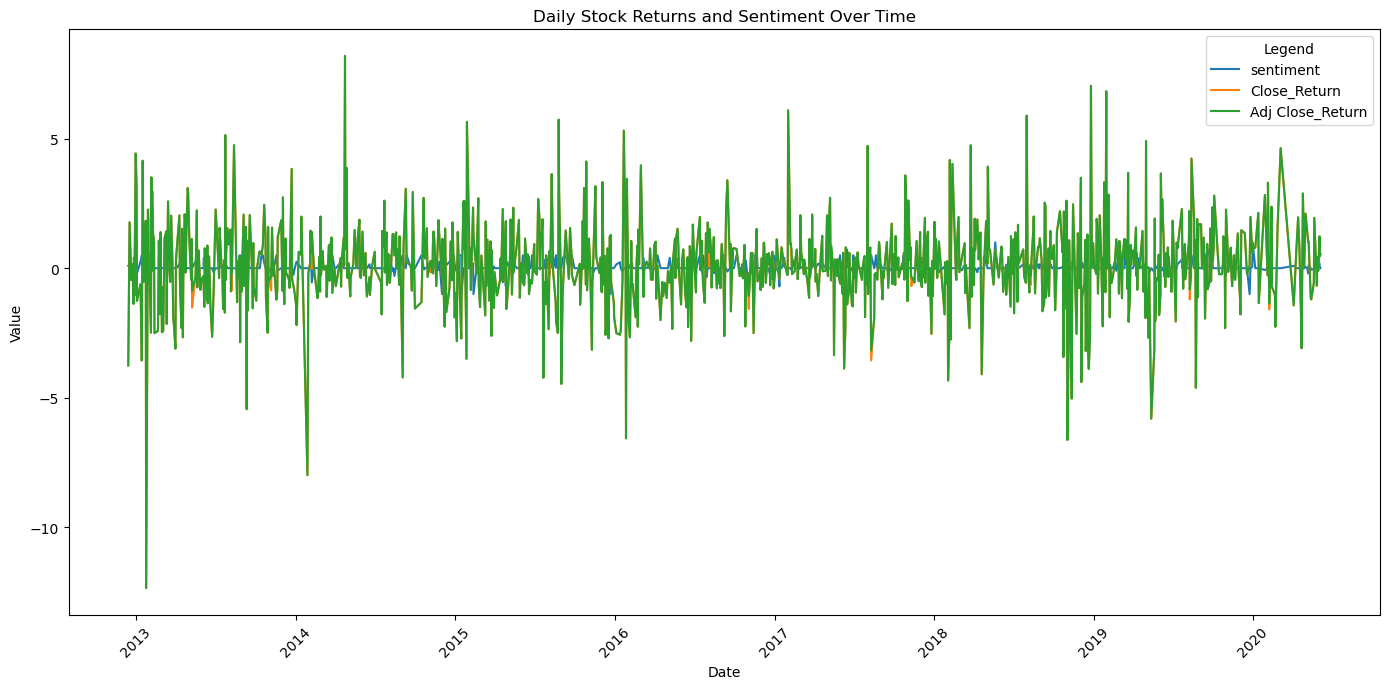

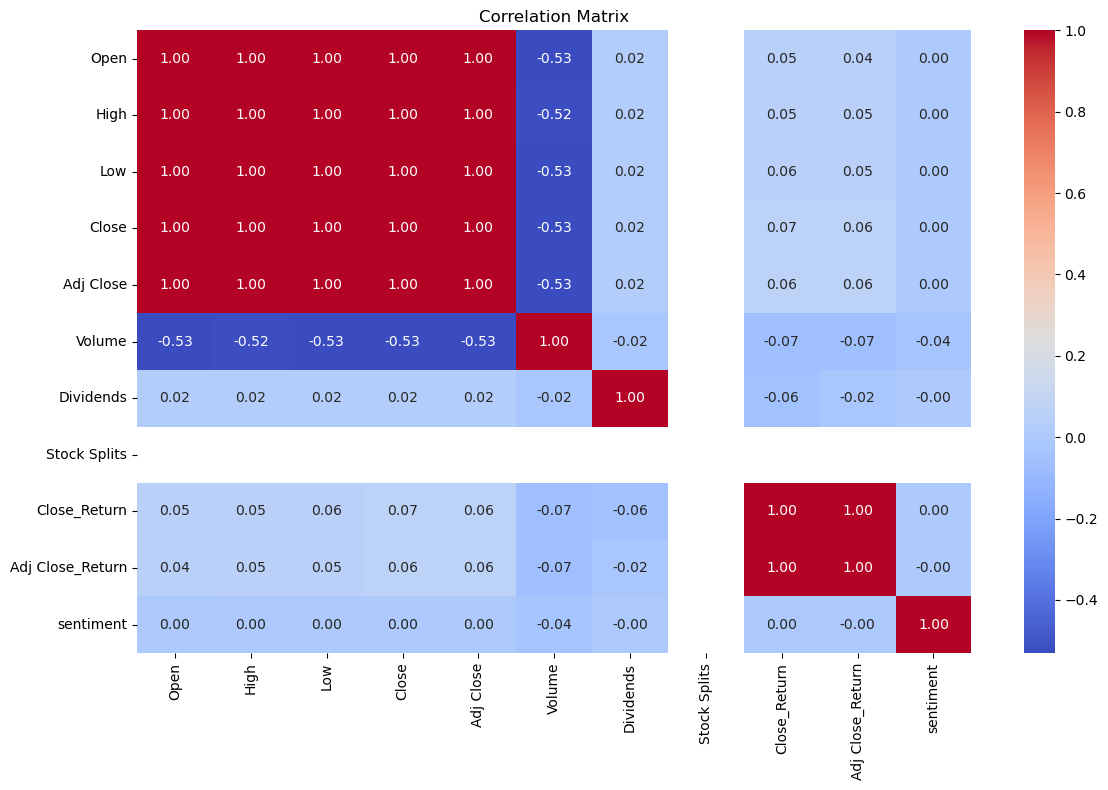

In [4]:


# Remove duplicate columns from combined_stock_df
combined_stock_df = combined_stock_df.loc[:, ~combined_stock_df.columns.duplicated()]

# Verify column names after deduplication
print("Columns after deduplication:")
print(combined_stock_df.columns)

# Calculate daily returns for each stock
return_columns = []
for column in combined_stock_df.columns:
    if 'Close' in column:
        # Calculate daily returns and add to DataFrame
        return_column = f'{column}_Return'
        combined_stock_df[return_column] = combined_stock_df[column].pct_change() * 100
        return_columns.append(return_column)

# Drop rows with NaN values resulting from pct_change
combined_stock_df.dropna(inplace=True)

# Ensure the sentiment column exists in news_df
print("Columns in news_df:")
print(news_df.columns)

# Combine sentiment data with stock returns data
combined_df = pd.merge(combined_stock_df, news_df[['sentiment']], left_index=True, right_index=True, how='inner')

# Calculate correlation matrix
correlation_matrix = combined_df.corr()

# Print correlation of sentiment with stock returns
print("Correlation of sentiment with stock returns:")
print(correlation_matrix.filter(like='Return').filter(like='sentiment'))

# Visualization

# Plot Daily Returns vs Sentiment
plt.figure(figsize=(14, 7))
sns.lineplot(data=combined_df[['sentiment'] + return_columns], dashes=False)
plt.title('Daily Stock Returns and Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Legend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Daily stock return and sentiment ')
plt.show()

# Plot Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation matrix ')
plt.show()